# Core API

> Scikit-learn compatible transforms for spectroscopic data preprocessing.

In [ ]:
#| default_exp core

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from fastcore.all import *
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from typing import Callable
import pywt

In [ ]:
#| eval: false
from soilspecdata.datasets.ossl import get_ossl
from sklearn.pipeline import Pipeline
from soilspectfm.visualization import plot_spectra
from matplotlib import pyplot as plt
from soilspectfm.visualization import plot_spectra_comparison
from soilspectfm.utils import load_toy_mir, load_toy_noisy_mir

In [ ]:
#| eval: false
X, ws = load_toy_mir()

## Baseline corrections

In [ ]:
#| exports
class SNV(BaseEstimator, TransformerMixin):
    """
    Standard Normal Variate transformation with flexible centering and scaling.
    
    Common centering functions:
    
        - np.mean: Standard choice, sensitive to outliers
        - np.median: Robust to outliers, slower computation
        - np.min: Ensures positive values, sensitive to noise
        - lambda x, **kw: 0: No centering, preserves absolute values
    
    Common scaling functions:
    
        - np.std: Standard choice, assumes normal distribution
        - lambda x, **kw: np.sqrt(np.mean(x**2, **kw)): RMS, good for baseline variations
        - scipy.stats.iqr: Robust to outliers, ignores extreme peaks
        - lambda x, **kw: np.max(x, **kw) - np.min(x, **kw): Preserves relative peaks
        - lambda x, **kw: np.median(np.abs(x - np.median(x, **kw)), **kw): Most robust, slower
    """
    def __init__(self, 
                 center_func: Callable=np.mean, # Function to center the data
                 scale_func: Callable=np.std, # Function to scale the data
                 eps: float=1e-10 # Small value to avoid division by zero
                 ):
        store_attr()
    def fit(self, X, y=None): return self
    def transform(self, 
                  X: np.ndarray # Spectral data to be transformed
                  ) -> np.ndarray: # Transformed spectra
        center = self.center_func(X, axis=1, keepdims=True)
        scale = self.scale_func(X - center, axis=1, keepdims=True) + self.eps
        return (X - center) / scale

In [ ]:
#|eval: false
X_tfm = SNV().fit_transform(X)

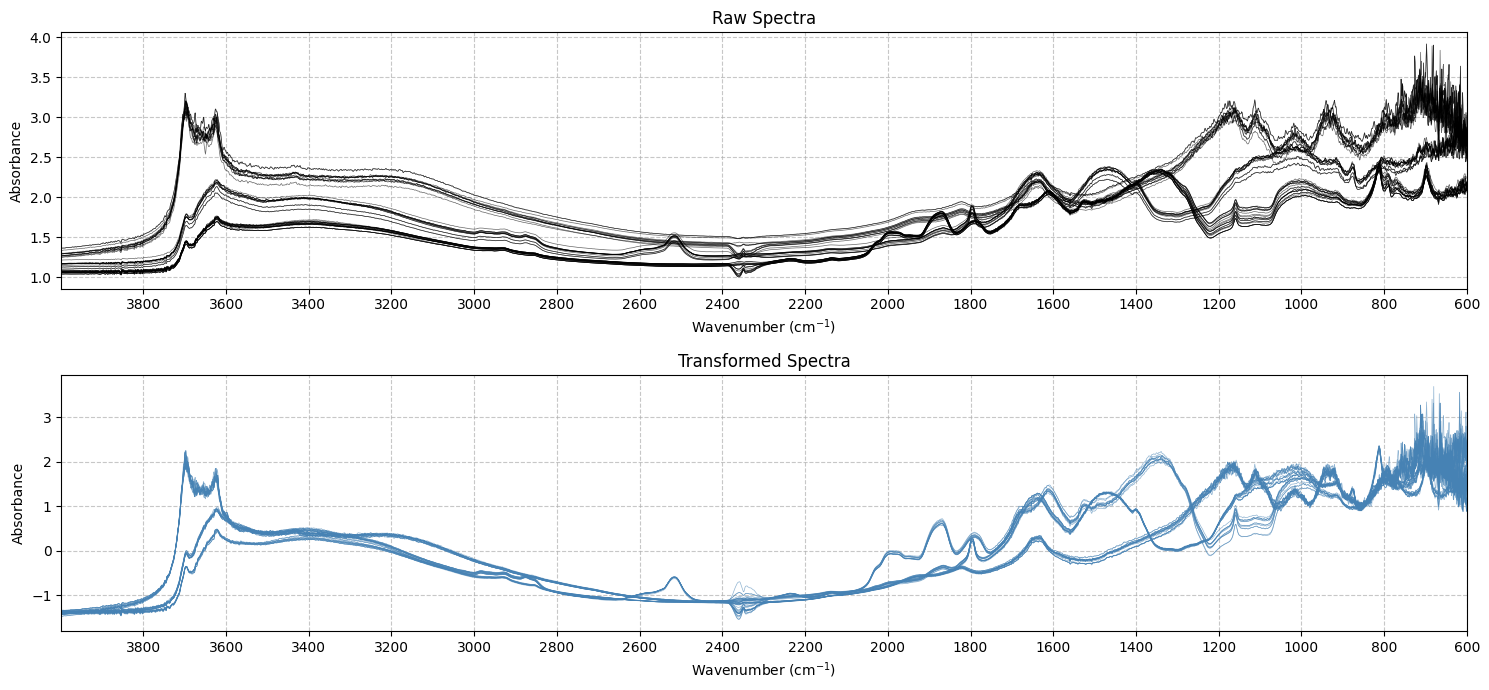

In [ ]:
#| eval: false
plot_spectra_comparison(
    X,
    SNV().fit_transform(X),
    ws,
    raw_title='Raw Spectra',
    transformed_title='Transformed Spectra'
);

In [ ]:
#| exports
class MSC(BaseEstimator, TransformerMixin):
    "Multiplicative Scatter Correction with fastai-style implementation"
    def __init__(self, 
                 reference_method: Union[str, np.ndarray] = 'mean', # Method to compute reference spectrum ('mean'/'median') or custom reference spectrum
                 n_jobs: Optional[int] = None # Number of parallel jobs to run. None means using all processors
                 ):
        store_attr()
        self.reference_ = None
        
    def _compute_reference(self, x: np.ndarray):
        "Compute reference spectrum from array using specified method"
        if isinstance(self.reference_method, str):
            assert self.reference_method in ['mean', 'median'], "reference_method must be 'mean' or 'median'"
            return np.mean(x, axis=0) if self.reference_method == 'mean' else np.median(x, axis=0)
        return np.array(self.reference_method)
    
    def fit(self, X: np.ndarray, y=None):
        "Compute the reference spectrum"
        self.reference_ = self._compute_reference(X)
        return self
    
    def _transform_single(self, 
                          x: np.ndarray # Spectral data to be transformed
                          ) -> np.ndarray: # Transformed spectra
        "Transform a single spectrum"
        coef = np.polyfit(self.reference_, x, deg=1)
        return (x - coef[1]) / coef[0]
    
    def transform(self, 
                  X: np.ndarray # Spectral data to be transformed
                  ) -> np.ndarray: # Transformed spectra
        "Apply MSC to the spectra"
        if self.reference_ is None: raise ValueError("MSC not fitted. Call 'fit' first.")
        return np.array(parallel(self._transform_single, X, n_workers=self.n_jobs))

In [ ]:
#| eval: false
X_tfm = MSC(reference_method='median').fit_transform(X)

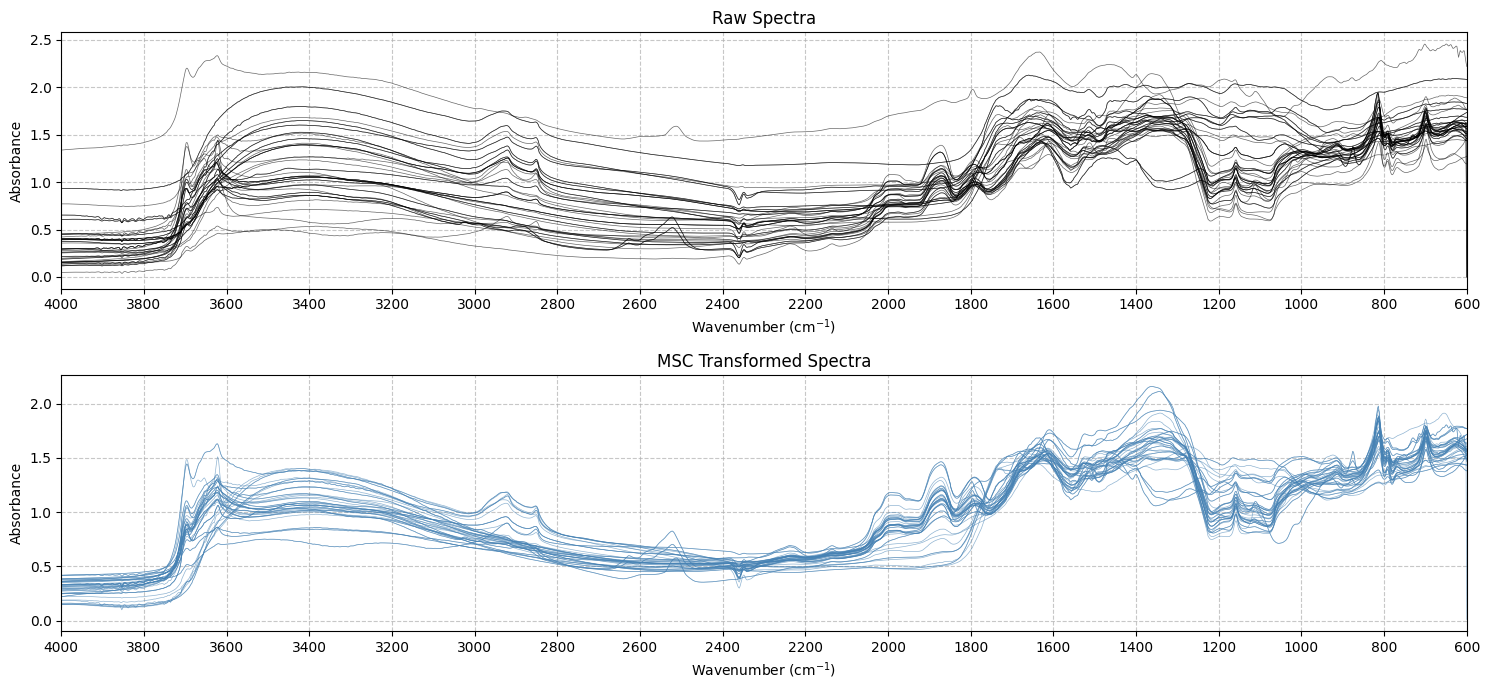

In [ ]:
#| eval: false
plot_spectra_comparison(
    X,
    MSC().fit_transform(X),
    ws,
    raw_title='Raw Spectra',
    transformed_title='MSC Transformed Spectra'
);

References:
- https://eigenvector.com/wp-content/uploads/2020/01/RobustFittingtoBasisFunctionsIII.pdf
- https://nirpyresearch.com/two-methods-baseline-correction-spectral-data/
- https://diposit.ub.edu/dspace/bitstream/2445/188026/1/2014_IEEE_Adaptive_MarcoS_postprint.pdf

In [ ]:
class ALS(BaseEstimator, TransformerMixin):
    "Asymmetric least squares detrending"
    pass

## Derivatives

In [ ]:
#| exports
class TakeDerivative(BaseEstimator, TransformerMixin):
    "Creates scikit-learn derivation + savitsky-golay smoothing custom transformer"
    def __init__(self, 
                 window_length=11, # Window length for the savgol filter
                 polyorder=1, # Polynomial order for the savgol filter
                 deriv=1 # Derivation degree
                 ):
        self.window_length = window_length
        self.polyorder = polyorder
        self.deriv = deriv

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return savgol_filter(X, self.window_length, self.polyorder, self.deriv)

How to use the TakeDerivative transformer in combination with the SNV transformer?

In [ ]:
#| eval: false
pipe = Pipeline([('snv', SNV()), 
                 ('deriv', TakeDerivative(deriv=1))
                 ])

X_tfm = pipe.fit_transform(X)

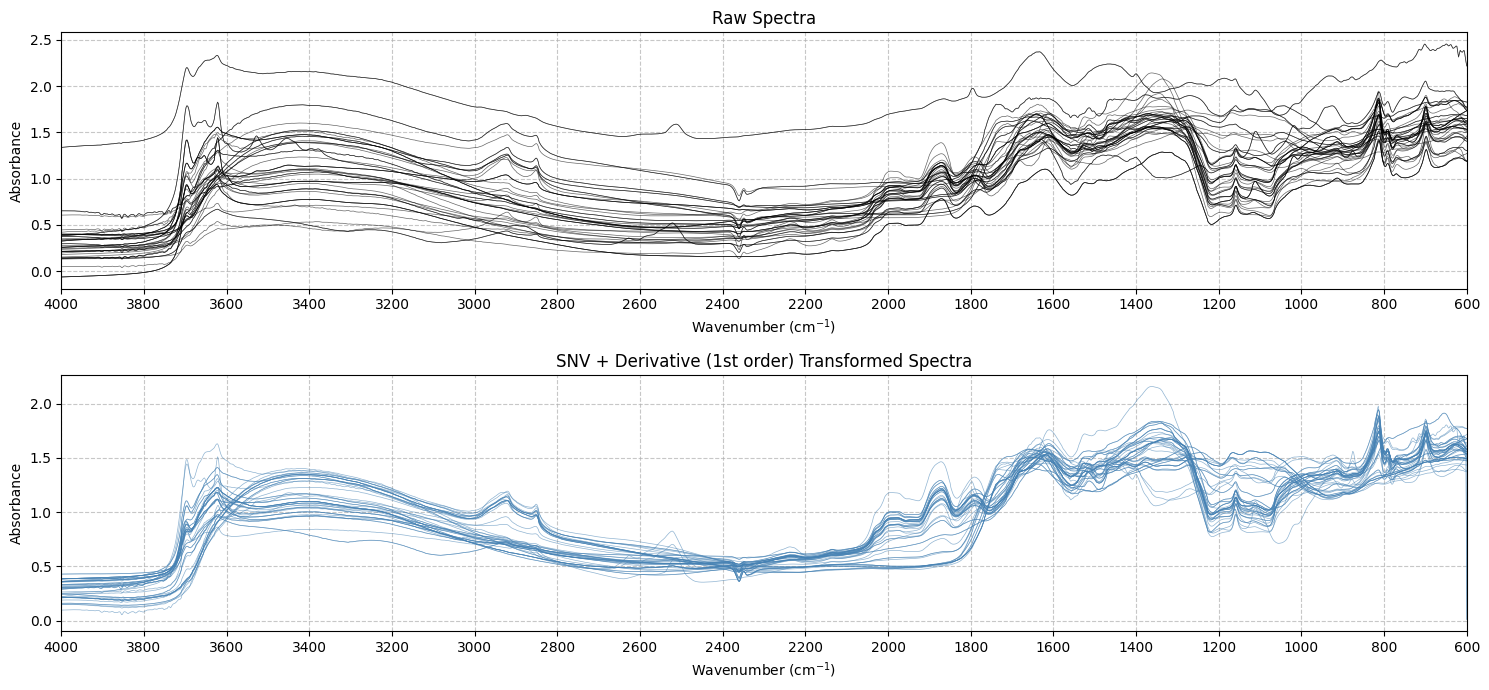

In [ ]:
#| eval: false
plot_spectra_comparison(
    X,
    MSC().fit_transform(X),
    ws,
    raw_title='Raw Spectra',
    transformed_title='SNV + Derivative (1st order) Transformed Spectra'
);


## Smoothing

In [ ]:
#| exports
class WaveletDenoise(BaseEstimator, TransformerMixin):
    "Wavelet denoising transformer compatible with scikit-learn."    
    def __init__(self, 
                 wavelet:str='db6', # Wavelet to use for decomposition
                 level:Optional[int]=None, # Decomposition level. If None, maximum level is used
                 threshold_mode:str='soft' # Thresholding mode  ('soft'/'hard')
                 ):
        store_attr()
        
    def _denoise_single(self, spectrum):
        "Denoise a single spectrum"
        # If level is None, calculate maximum possible level
        if self.level is None:
            self.level_ = pywt.dwt_max_level(len(spectrum), 
                                             pywt.Wavelet(self.wavelet).dec_len)
        else:
            self.level_ = self.level
            
        coeffs = pywt.wavedec(spectrum, self.wavelet, level=self.level_)
        
        # Calculate threshold using MAD estimator
        detail_coeffs = np.concatenate([c for c in coeffs[1:]])
        sigma = np.median(np.abs(detail_coeffs)) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(len(spectrum)))
        
        # Apply threshold to detail coefficients
        new_coeffs = list(coeffs)
        for i in range(1, len(coeffs)):
            new_coeffs[i] = pywt.threshold(coeffs[i], 
                                         threshold * (1/2**((self.level_-i)/2)),
                                         mode=self.threshold_mode)

        denoised = pywt.waverec(new_coeffs, self.wavelet)
        return denoised[:len(spectrum)]
    
    def fit(self, X, y=None):
        "Fit the transformer (no-op)"
        return self
    
    def transform(self, X):
        "Apply wavelet denoising to spectra."
        X = np.asarray(X)
        X_denoised = np.zeros_like(X)
        for i in range(X.shape[0]): X_denoised[i] = self._denoise_single(X[i])
        return X_denoised

X shape: (48, 3315), First 5 wavenumbers: [599.91153162 600.93702142 601.96251122 602.98800102 604.01349081]


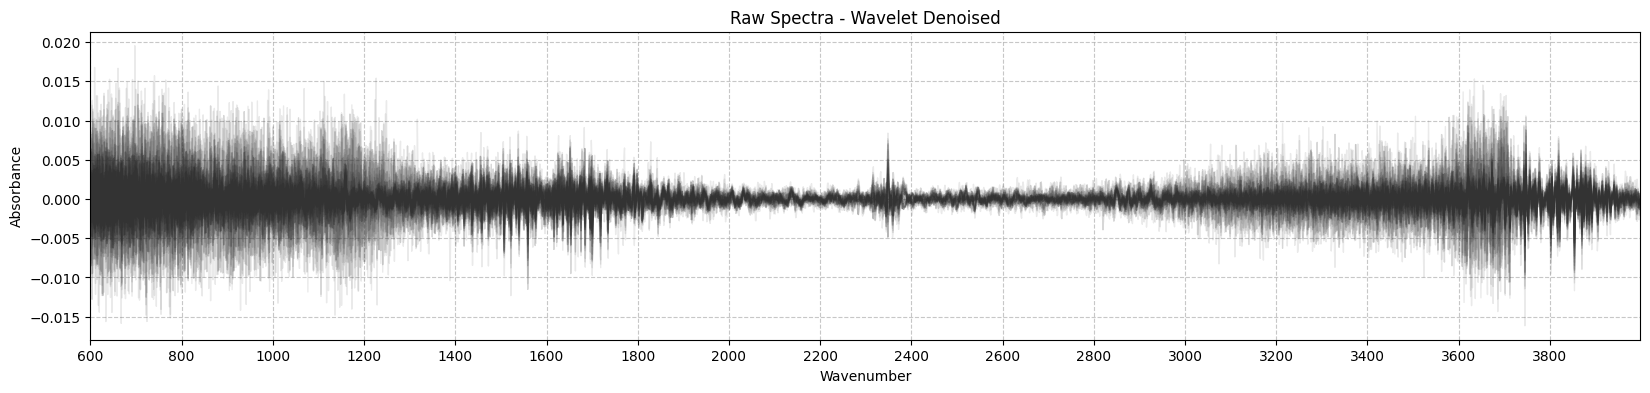

In [ ]:
#| eval: false
X, ws, _ = load_toy_noisy_mir()
print(f'X shape: {X.shape}, First 5 wavenumbers: {ws[:5]}')

denoiser = WaveletDenoise(wavelet='db6', level=5, threshold_mode='soft')
X_denoised = denoiser.fit_transform(X)
plot_spectra(X - X_denoised, ws, alpha=0.1, title='Raw Spectra - Wavelet Denoised');

In [ ]:
#| exports
class SavGolSmooth(BaseEstimator, TransformerMixin):
    "Savitzky-Golay smoothing transformer compatible with scikit-learn."
    def __init__(self, 
                 window_length:int=15, # Window length for the savgol filter
                 polyorder:int=3, # Polynomial order for the savgol filter
                 deriv:int=0 # Derivation degree
                 ):
        store_attr()
        
    def _validate_params(self):
        "Validate parameters."
        if self.window_length % 2 == 0:
            raise ValueError("window_length must be odd")
        if self.window_length <= self.polyorder:
            raise ValueError("window_length must be greater than polyorder")
        if self.deriv > self.polyorder:
            raise ValueError("deriv must be <= polyorder")
            
    def fit(self, 
            X:np.ndarray,# Spectral data to be smoothed.
            y:Optional[np.ndarray]=None # Ignored
            ):
        "Validate parameters and fit the transformer."
        self._validate_params()
        return self
    
    def transform(self, 
                  X: np.ndarray # Spectral data to be smoothed.
                  ) -> np.ndarray: # Smoothed spectra
        "Apply Savitzky-Golay filter to spectra."
        X = np.asarray(X)
        X_smoothed = np.zeros_like(X)
        
        for i in range(X.shape[0]):
            X_smoothed[i] = savgol_filter(X[i], 
                                        window_length=self.window_length,
                                        polyorder=self.polyorder,
                                        deriv=self.deriv)
        
        return X_smoothed

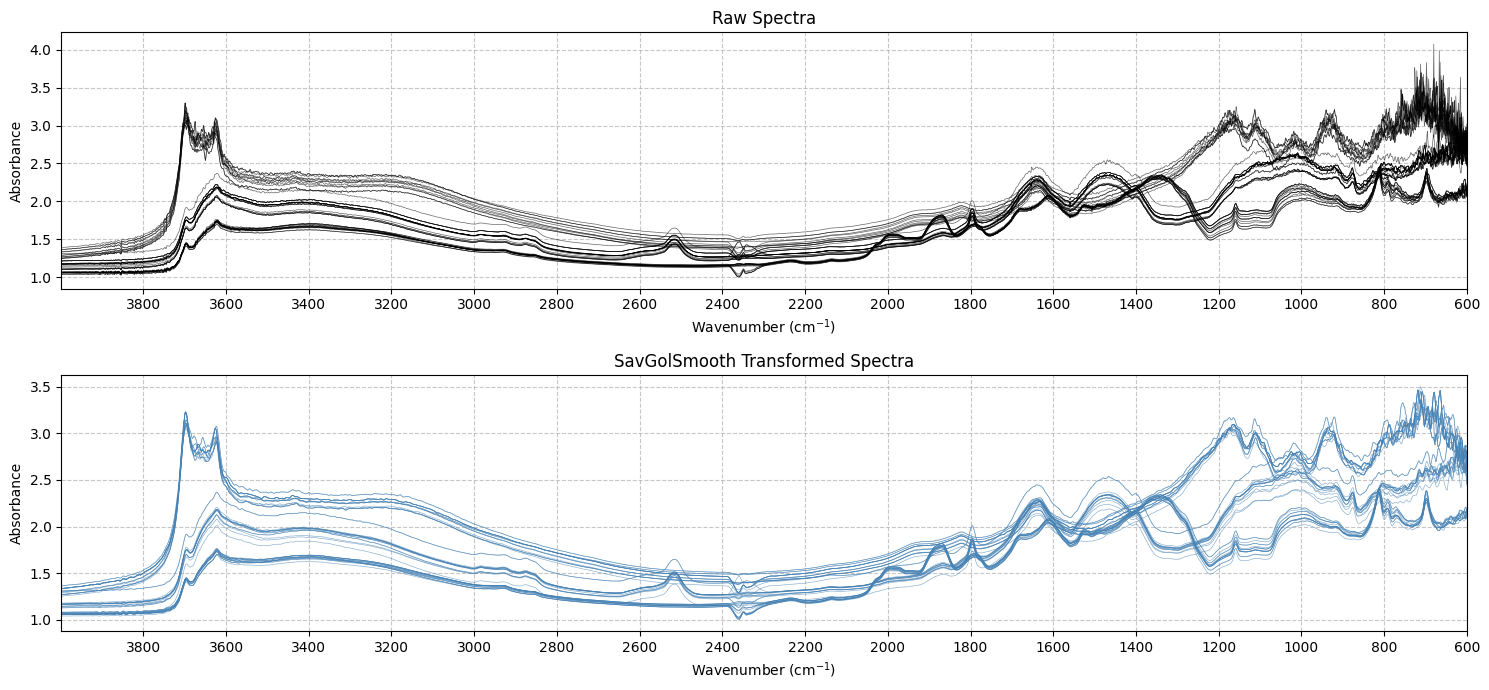

In [ ]:
#| eval: false
smoother = SavGolSmooth(window_length=15, polyorder=3)
X_smoothed = smoother.fit_transform(X)
plot_spectra_comparison(X, X_smoothed, ws, raw_title='Raw Spectra', transformed_title='SavGolSmooth Transformed Spectra');

## Other Transformations

In [ ]:
#| exports
class ToAbsorbance(BaseEstimator, TransformerMixin):
    "Creates scikit-learn transformer to transform reflectance to absorbance"
    def __init__(self, 
                 eps: float=1e-5 # Small value to avoid log(0)
                 ): self.eps = eps
    def fit(self, X, y=None): return self
    def transform(self, X, y=None): return -np.log10(np.clip(X, self.eps, 1))

In [ ]:
#| exports
class Resample(BaseEstimator, TransformerMixin):
    "Resampling transformer compatible with scikit-learn."
    def __init__(self, 
                 source_x: np.ndarray, # Source x-axis points (wavenumbers or wavelengths)
                 target_x: np.ndarray, # Target x-axis points (wavenumbers or wavelengths) for resampling
                 interpolation_kind: str='cubic' # Type of spline interpolation to use
                 ):
        store_attr()
        
    def fit(self, 
            X: np.ndarray, # Spectral data to be resampled
            y: np.ndarray=None # Not used
            ):
        "No-op in that particular case"
        return self
    
    def transform(self, 
                  X: np.ndarray # Spectral data to be resampled
                  ):
        "Resample spectra to new x-axis points."
        X = np.asarray(X)
        X_transformed = np.zeros((X.shape[0], len(self.target_x)))
        
        for i in range(X.shape[0]):
            cs = CubicSpline(self.source_x, X[i])
            X_transformed[i] = cs(self.target_x)
        
        return X_transformed

X_resampled.shape: (48, 1701), New wavenumbers: [600 602 604 606 608 610 612 614 616 618]


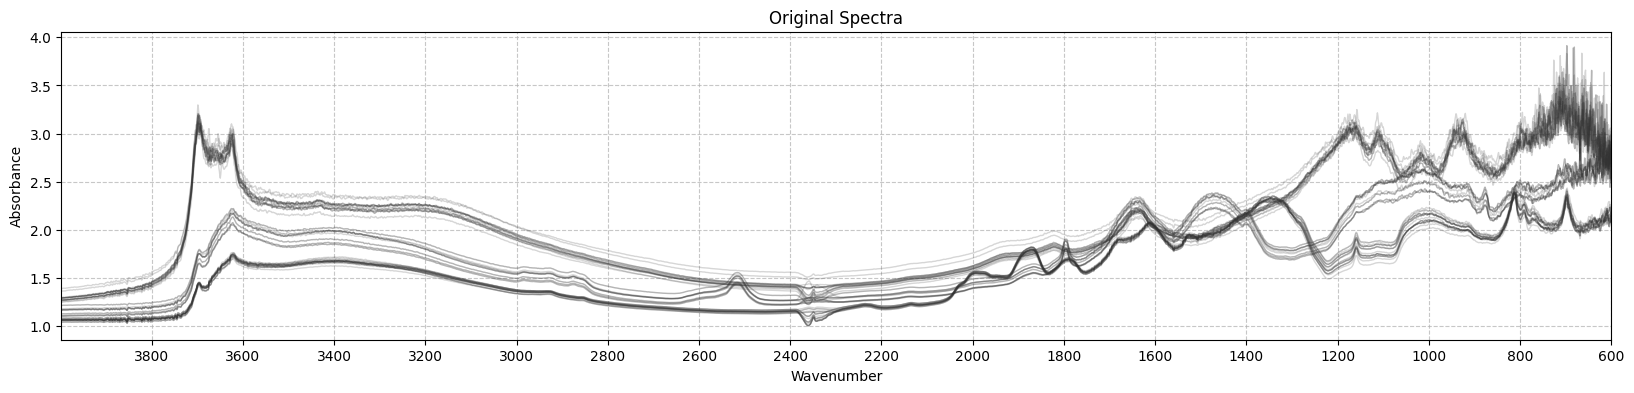

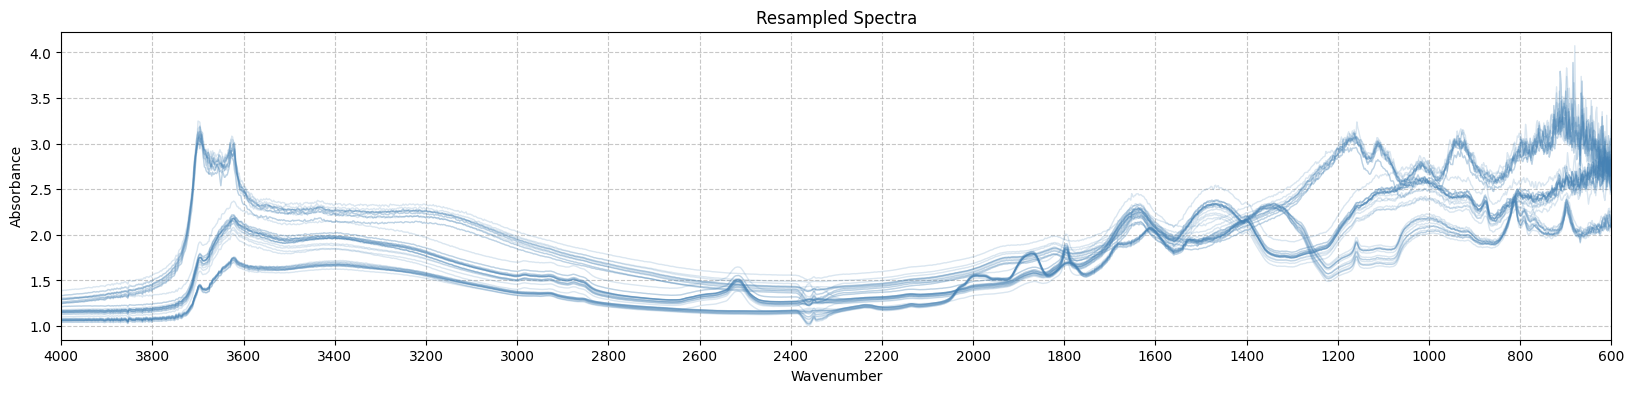

In [ ]:
#| eval: false
new_ws = np.arange(600, 4001, 2)  # New wavenumber axis
resampler = Resample(source_x=ws, target_x=new_ws)
X_resampled = resampler.fit_transform(X)
print(f'X_resampled.shape: {X_resampled.shape}, New wavenumbers: {new_ws[:10]}')

plot_spectra(X, ws, ascending=False,title='Original Spectra', alpha=0.2);
plot_spectra(X_resampled, new_ws, ascending=False,title='Resampled Spectra', alpha=0.2, color='steelblue');

In [ ]:
#| exports
class Trim(BaseEstimator, TransformerMixin):
    "Trims the spectra to the specified wavenumbers (or wavelengths) range."
    def __init__(self, 
                 ws: np.ndarray, # Wavenumbers or wavelengths
                 w_min: Optional[float]=None, # Minimum wavenumber or wavelength
                 w_max: Optional[float]=None # Maximum wavenumber or wavelength
                 ):
        store_attr()
        
    def fit(self, 
            X: np.ndarray, # Spectra to be trimmed
            y: Optional[np.ndarray]=None # Ignored
            ):
        "Store wavenumbers and compute indices for trimming"
        self.mask_ = (self.ws >= (self.w_min if self.w_min else -np.inf)) & \
                     (self.ws <= (self.w_max if self.w_max else np.inf))
        return self
    
    def transform(self, X: np.ndarray) -> np.ndarray:
        "Trim the spectra"
        return X[:, self.mask_]
    
    def get_wavenumbers(self) -> np.ndarray:
        "Return the trimmed wavenumbers"
        return self.ws[self.mask_]

X_trimmed.shape: (50, 1676), Trimmed wavenumbers: [650 652 654 656 658 660 662 664 666 668]


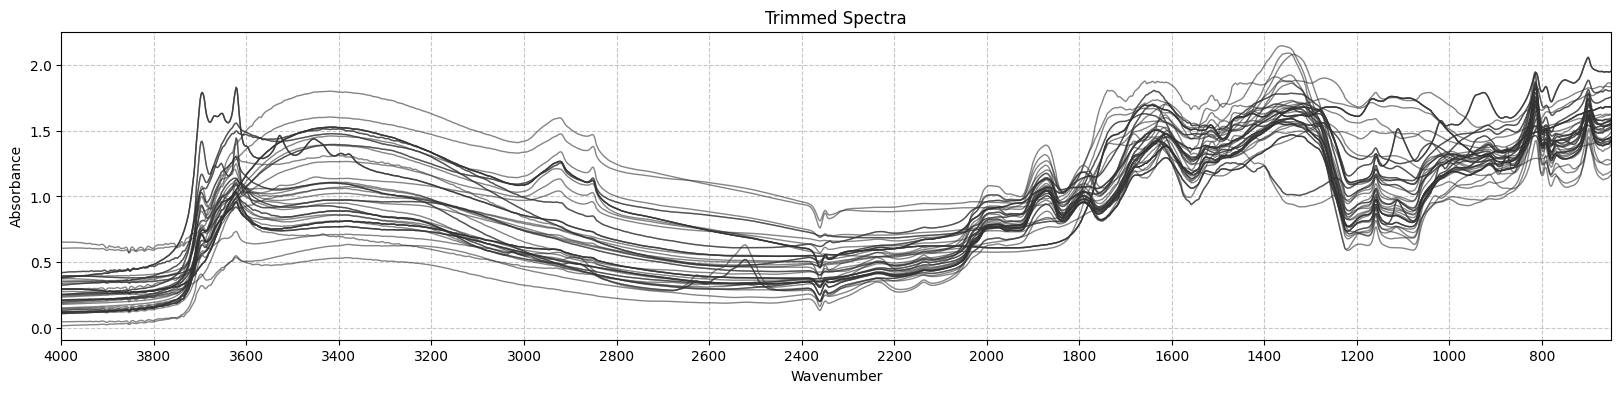

In [ ]:
#| eval: false
trimmer = Trim(ws, w_min=650, w_max=4000)
X_trimmed = trimmer.fit_transform(X)

print(f'X_trimmed.shape: {X_trimmed.shape}, Trimmed wavenumbers: {trimmer.get_wavenumbers()[:10]}')
plot_spectra(X_trimmed, trimmer.get_wavenumbers(), title='Trimmed Spectra', ascending=False);